In [63]:
import vaex
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
from scipy.interpolate import interp1d
from scipy.stats import rv_continuous, norm, uniform
from scipy.integrate import simps, quad
from scipy import optimize
import emcee
import corner
from os.path import join, abspath
from os import pardir, mkdir
import seaborn as sns
import sys


In [2]:
# import utils
util_dir = abspath(pardir)
sys.path.insert(0, util_dir)

# 1. Constant Density

In [4]:
density = 50 # star/pc

zmax = 100 # pc

z = np.linspace(-zmax, zmax, 10) # pc
N = int(2*zmax*density)
zz = uniform.rvs(size=N)*2*zmax - zmax

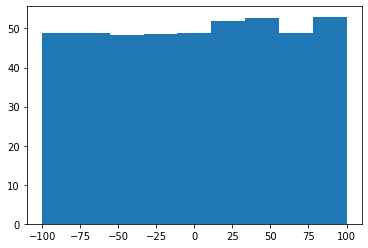

In [5]:
plt.hist(zz, bins=z,weights=np.ones_like(zz)/(z[1]-z[0]))
plt.show()

In [6]:
def log_likelihood(theta, z):
    def lambda_f(x):
        return np.ones((len(x), len(theta)))*theta
    # log_lambda = np.log(theta)*len(z)
    log_lambda = np.sum(np.log(lambda_f(z)), axis=0)
    integral = (np.max(z)-np.min(z))*theta
    return log_lambda - integral

def log_prior(theta):
    result = uniform.logpdf(theta, 0, 100)
    return result

def log_posterior(theta, z):
    prior = log_prior(theta)
    likelihood = log_likelihood(theta, z)
    result = prior + likelihood
    finite = np.isinf(prior)
    result[finite] = -np.inf
    # print(result+7000)
    return result
    

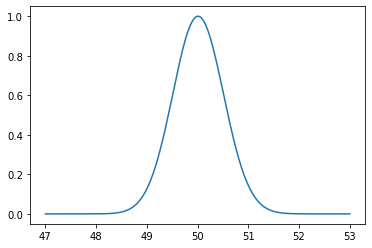

In [7]:
theta = np.linspace(47, 53, 1000)
posterior = log_posterior(theta, zz)
posterior = np.exp(posterior - np.max(posterior))
plt.plot(theta, posterior)


In [79]:
def hdi_interval(func, a, b, ymax, xmax, std, level=10, hdi=0.68):
    yup = ymax*0.999
    ydown = 0
    lower = a
    upper = b
    for i in range(level):
        dy = (yup-ydown)/10
        for ynew in np.arange(yup, ydown, -dy):
            sol = optimize.root(lambda y: func(y) - ynew, [xmax-std, xmax+std])
            area = quad(func, sol.x[0], sol.x[1])[0]
            if area > hdi:
                yup = ynew+dy
                ydown = ynew
                lower = sol.x[0]
                upper = sol.x[1]
                break
    return lower, upper

def inference_bayesian(post, x, hdi=0.68, level=10):
    interp_raw = interp1d(x, post, kind='cubic', fill_value='extrapolate')
    norm = np.trapz(interp_raw(x), x)
    interp = lambda x: interp_raw(x)/norm
    xmax = optimize.fmin(lambda x: -1*interp(x), x[np.argmax(interp(x))])
    mean = quad(lambda x: x*interp(x), np.min(x), np.max(x))[0]
    std = np.sqrt(quad(lambda x: (x-mean)**2*interp(x), np.min(x), np.max(x))[0])
    lower, upper = hdi_interval(interp, x[0], x[-1], interp(xmax), xmax, std, level=level, hdi=hdi)
    return xmax, lower, upper

In [162]:
theta[np.argmax(posterior)]

50.003003003003

Optimization terminated successfully.
         Current function value: -0.797734
         Iterations: 16
         Function evaluations: 32


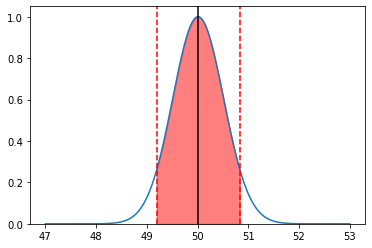

[50.00900901]
[0.8180731]
[0.82710311]


In [81]:
xmax, lower, upper = inference_bayesian(posterior, theta, hdi=0.9)
plt.plot(theta, posterior)
plt.axvline(lower, color='r', ls="--")
plt.axvline(upper, color='r', ls="--")
plt.fill_between(theta, posterior, where=(theta>lower)&(theta<upper), color='r', alpha=0.5)
plt.axvline(xmax, color='k')
# plt.axhline(0)
plt.ylim(0)
plt.show()
print(xmax)
print(xmax-lower)
print(upper-xmax)

# 2. Gaussian Density

N:  1000
sigma:  19.947114020071634


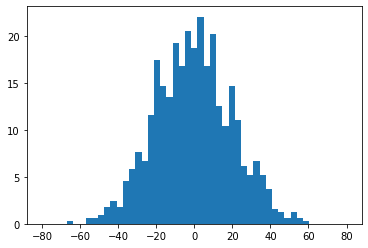

In [94]:
sigma = 20 # pc
N = 1000
density = N/np.sqrt(2*np.pi*sigma**2)
print("N: ", N)
print("sigma: ", density)

z = np.linspace(-4*sigma, 4*sigma, 50) # pc

zz = norm.rvs(loc=0, scale=sigma, size=N)

plt.hist(zz, bins=z, weights=np.ones_like(zz)/(z[1]-z[0]))
plt.show()

In [95]:
def log_likelihood(theta, z):
    args = ('sigma', 'N')
    sigma, N = itemgetter(*args)(theta)
    def lambda_f(x):
        return norm.pdf(x, loc=0, scale=sigma)*N
    log_lambda = np.sum(np.log(lambda_f(z)), axis=0)
    zz = np.linspace(np.min(z), np.max(z), 1000)
    integral = simps(lambda_f(zz), zz)
    return log_lambda - integral

def log_prior(theta, priors):
    args = ('sigma', 'N')
    sigma, N = itemgetter(*args)(theta)
    args = ('locs', 'scales')
    locs, scales = itemgetter(*args)(priors)
     
    uni_loc = np.array([locs['sigma'], locs['N']])
    uni_scale = np.array([scales['sigma'], scales['N']])
    uni_val = sigma, N
    # print(uni_val)
    log_uni = np.sum(uniform.logpdf(uni_val, loc=uni_loc, scale=uni_scale))
    return log_uni

def log_posterior(x, z, priors):
    theta = dict(sigma=x[0], N=x[1])
    prior = log_prior(theta, priors)
    if np.isinf(prior):
        return -np.inf
    likelihood = log_likelihood(theta, z)
    result = prior + likelihood
    return result

In [96]:
sigma = np.linspace(17, 23, 100)
N = np.linspace(900, 1100, 150)
locs=dict(sigma=10, N=500)
scales=dict(sigma=20, N=1000)
priors = dict(locs=locs, scales=scales)
posterior = np.zeros((len(sigma), len(N)))
for i, s in enumerate(sigma):
    for j, n in enumerate(N):
        theta = [s, n]
        posterior[i,j] = log_posterior(theta, zz, priors)
    print(i, end=" ")
posterior = np.exp(posterior - np.max(posterior))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

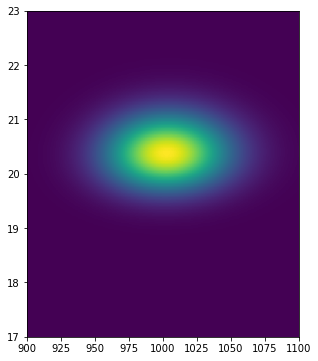

In [98]:
fig, ax = plt.subplots(figsize=(6,6))

ax.imshow(posterior, origin='lower', extent=[np.min(N), np.max(N), np.min(sigma), np.max(sigma)])
ax.set_aspect(40)

# 3. Gaussian 3 parameters with emcee

N:  1000
sigma:  19.947114020071634


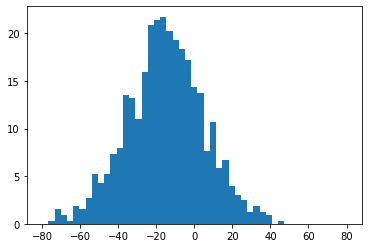

In [99]:
sigma = 20 # pc
loc = -15
N = 1000
density = N/np.sqrt(2*np.pi*sigma**2)
print("N: ", N)
print("sigma: ", density)

z = np.linspace(-4*sigma, 4*sigma, 50) # pc

zz = norm.rvs(loc=loc, scale=sigma, size=N)

plt.hist(zz, bins=z, weights=np.ones_like(zz)/(z[1]-z[0]))
plt.show()

In [102]:
def log_likelihood(theta, z):
    args = ('loc', 'sigma', 'N')
    loc, sigma, N = itemgetter(*args)(theta)
    def lambda_f(x):
        return norm.pdf(x, loc=loc, scale=sigma)*N
    log_lambda = np.sum(np.log(lambda_f(z)), axis=0)
    zz = np.linspace(np.min(z), np.max(z), 1000)
    integral = simps(lambda_f(zz), zz)
    return log_lambda - integral

def log_prior(theta, priors):
    args = ('loc', 'sigma', 'N')
    loc, sigma, N = itemgetter(*args)(theta)
    args = ('locs', 'scales')
    locs, scales = itemgetter(*args)(priors)
     
    uni_loc = np.array([locs['loc'], locs['sigma'], locs['N']])
    uni_scale = np.array([scales['loc'], scales['sigma'], scales['N']])
    uni_val = loc, sigma, N
    log_uni = np.sum(uniform.logpdf(uni_val, loc=uni_loc, scale=uni_scale))
    return log_uni

def log_posterior(x, z, priors):
    theta = dict(loc=x[0], sigma=x[1], N=x[2])
    prior = log_prior(theta, priors)
    if np.isinf(prior):
        return -np.inf
    likelihood = log_likelihood(theta, z)
    result = prior + likelihood
    return result

In [103]:
ndim = 3
nwalkers = ndim*2+10


loc_loc, loc_scale = -50, 60
loc_0 = np.random.uniform(low=loc_loc, high=loc_loc+loc_scale, size=nwalkers)

sigma_loc, sigma_scale = 10, 20
sigma_0 = np.random.uniform(low=sigma_loc, high=sigma_loc+sigma_scale, size=nwalkers)

N_loc, N_scale = 700, 500
N_0 = np.random.uniform(low=N_loc, high=N_loc+N_scale, size=nwalkers)

p0 = np.array([loc_0, sigma_0, N_0]).T

In [104]:
locs = dict(loc=loc_loc, sigma=sigma_loc, N=N_loc)

scales = dict(loc=loc_scale, sigma=sigma_scale, N=N_scale)
priors = dict(locs=locs, scales=scales)
data = zz
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data, priors])

In [105]:
state = sampler.run_mcmc(p0, 200, progress=True)
state

100%|██████████| 200/200 [00:06<00:00, 32.68it/s]


State([[ -14.10629817   20.23683761  928.5036937 ]
 [ -15.14109814   20.35195103  990.40365943]
 [ -15.92031032   20.06126401  984.13933172]
 [ -15.13106883   20.32193961 1007.92620412]
 [ -15.39190925   20.54269049  993.31888339]
 [ -14.46655383   19.64101261  980.81637545]
 [ -15.79132865   20.09698802 1027.57897399]
 [ -15.71868313   21.37594081 1007.71285524]
 [ -15.55738977   19.61716322  981.22845648]
 [ -15.9457407    20.18222009  991.6562856 ]
 [ -15.32152844   20.13606608  985.75454213]
 [ -15.48851904   20.02111921  977.15977051]
 [ -15.59276281   20.33422007 1080.16215011]
 [ -14.66784661   19.92177601 1031.84231579]
 [ -15.09458609   20.04126281 1006.94542493]
 [ -14.63091138   20.22198177  984.40451259]], log_prob=[1466.15758457 1470.59696316 1469.74861859 1470.62953276 1470.6110304
 1468.21012699 1469.80810026 1468.68202887 1468.88984397 1469.97882468
 1470.38303908 1469.97904073 1467.65057825 1469.2122113  1470.31326217
 1469.95260438], blobs=None, random_state=('MT19937

Text(0.5, 0, 'step number')

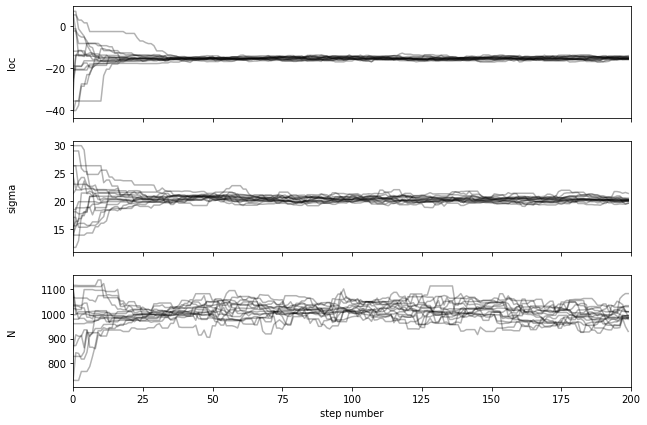

In [106]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["loc", "sigma", "N",]
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [107]:
sampler.reset()
sampler.run_mcmc(state, 5000, progress=True)

100%|██████████| 5000/5000 [02:32<00:00, 32.78it/s]


State([[ -15.12210804   19.72002026  996.48399247]
 [ -15.33214562   20.32530325  977.34822543]
 [ -14.10711344   21.50737659  997.56864299]
 [ -15.26993567   20.30147227  985.99441972]
 [ -15.5881315    20.90360995  926.62926085]
 [ -14.471053     20.07062561 1019.06132376]
 [ -14.58013732   19.88890729 1037.16589997]
 [ -16.14493238   20.46445674  983.01363677]
 [ -14.2640329    21.27797161 1026.31775659]
 [ -14.90473454   21.79430898 1059.53406066]
 [ -16.20703274   20.37107919  975.3171655 ]
 [ -14.80522436   20.76307556 1006.08029749]
 [ -15.68714902   20.16755335 1047.38210337]
 [ -14.73135813   20.25676801  991.67679608]
 [ -13.97870808   21.27109377  976.15043003]
 [ -15.18920701   19.96595604 1015.94638106]], log_prob=[1469.51355748 1470.36716875 1467.02518272 1470.53688888 1467.098987
 1469.47259131 1468.81754465 1469.62353918 1467.92456868 1465.53924773
 1469.30676534 1470.20663065 1469.33696394 1470.22738904 1467.14660408
 1470.11207017], blobs=None, random_state=('MT19937'

Text(0.5, 0, 'step number')

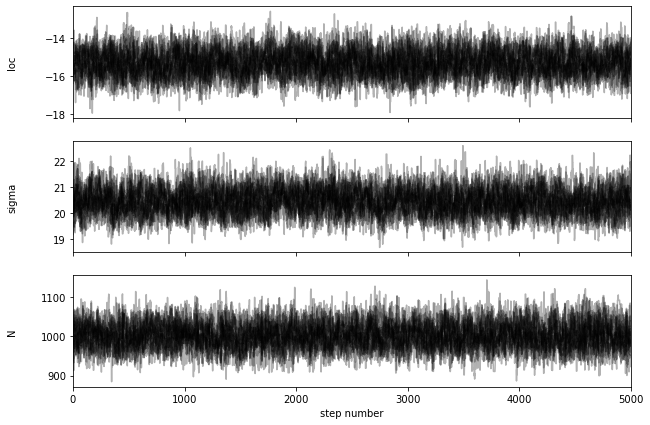

In [108]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["loc", "sigma", "N"]
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [109]:
flat_samples = sampler.get_chain(flat=True)
flat_samples

array([[ -14.22564726,   20.25298152,  938.18810803],
       [ -15.14447163,   20.36204576,  984.50972342],
       [ -15.91145349,   20.01913768,  981.52134291],
       ...,
       [ -14.73135813,   20.25676801,  991.67679608],
       [ -13.97870808,   21.27109377,  976.15043003],
       [ -15.18920701,   19.96595604, 1015.94638106]])

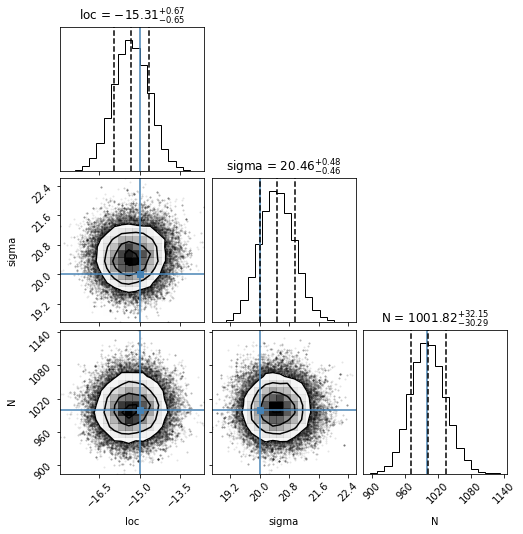

In [112]:
fig = corner.corner(
    flat_samples, labels=["loc", "sigma", "N"],
    truths=[loc, sigma, N],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={"fontsize": 12},
    
)

# 4. Modelling number density with 1 parameter